# Assignment 7: Regularization - Bagging, Early Stopping and Dropout (deadline: 22 Dec, 23:59)

### Exercise 1. Regularization: Bagging (7 points)

**Goal:** Study the effects of **bagging** regularization on Decision Tree based methods against a single instance of such a classifier.

Bagging, briefly mentioned in the Lecture 6, refers to an ensemble machine learning method. The Bagging scheme, suggested to be used in this exercise, samples instances from the training data with replacement and creates multiple training subsets. For each of these subsets, a new regressor is constructed internally and finally, all combined to produce the result. For more details read: 

1. Scikit Learn Documentation for Bagging Regressor. http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#id6

2. Bootstrap Aggregating Wikipedia Article. https://en.wikipedia.org/wiki/Bootstrap_aggregating

Implement a bagging regularization scheme using ***DecisionTreeRegressor***, a Decision Tree based classifier from the python package ***sklearn.tree***. To implement the bagging scheme you can use ***BaggingRegressor*** available in the python package ***sklearn.ensemble***. Fill in the code pieces marked by "# TODO" in the following notebook to complete this assignment. Finally, comment on the results you obtain.

Note: to run the following code you will need to download **data.csv** from the NNIA's resource page on Piazza

---

In [1]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Define Estimators: Create an array of two estimators.
# First a "Tree" using "DecisionTreeRegressor" and second a Regularized version obtain using "BaggingRegressor"
# on this Tree, labelled "Bagging (Tree)". (2 points)

estimators = [("Tree", #TODO
               DecisionTreeRegressor()
              ),
              ("Bagging (Tree)", #TODO
               BaggingRegressor(base_estimator =DecisionTreeRegressor() ,max_samples=1.0,
                                bootstrap=True)
              )]

In [3]:
n_estimators = len(estimators)
np.random.seed(0)

#Load Data
data = pd.read_csv('data.csv')

#Drop Player Field
data = data.drop('Player', axis=1)

#Set variable y with 'Salary' column and then drop it from data
y = data['Salary'].as_matrix()
data = data.drop('Salary', axis=1)

#Convert data to an numpy array x
x = data.as_matrix()

# Split x in X_train (80 %) and X_test (20 %),  while constructing the corresponding y_train and y_test
n_train = np.int(0.8 * len(x) )
n_test = len(x) - n_train
X_train = x[:n_train,:]
y_train = y[:n_train]
X_test = x[n_train:,:]
y_test = y[n_train:]

2
Tree: 152196.4062 (error)
Bagging (Tree): 64003.2045 (error)


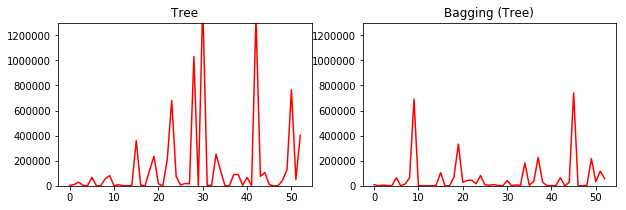

In [4]:
# Plot Figures and report error using the different ensemble methods
fig = plt.figure(figsize=(10,3))
print(n_estimators)

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    #print (n, name, estimator) n ={0,1}, name = {Tree, Bagging (Tree)}, estimator is the function
    
    # Compute predictions
    y_predict = np.zeros(n_test)
    
    # Train the estimator (1 point)
    # TODO
    estimator.fit(X_train, y_train)
    #Predict results using the estimator on X_test (1 point)
    # TODO
    y_predict = estimator.predict(X_test)
    y_error = np.zeros(n_test)
    
    # Compute the sqaured error using y_test and y_predict and store it in y_error (1 point)
    # TODO
    for i in range(y_test.size):
        y_error[i] = (y_test[i] - y_predict[i])**2
    
    print("{0}: {1:.4f} (error)".format(name,np.mean(y_error)))
    
    # Plot the Result
    plt.subplot(1,n_estimators, n+1)
    plt.plot(np.arange(n_test), y_error, "r", label="$error(x)$")
    plt.ylim([0, 1300000])
    plt.title(name)

plt.show()

a) Explain the differences (in 2-3 sentences) between the plots you obtain for **Tree** and **Bagging (Tree)**. (2 points)

##### Bagging trains multiple decision trees, each on a different sample generated from the training data. Then Bagging would average all the predictions, which yields to output a lower error.

### Exercise 2. Regularization: Early Stopping (6 points)

**Goal:** To study how increasing neurons of a neural network (model complexity) affects the Early Stopping threshold.

Download **MNIST** dataset from the NNIA's resource page on Piazza. We first update the feedforward neural network code below (at "#TODO") to calculate training and validation error at every 100 iterations of the training scheme. Then using this code for a different number of neurons (50 and 200), plot the variation of training and validation error for every 100th iteration up to 700 iterations. Studying these plots answer the questions given below.

Note: to calculate the validation error use the test set as a proxy validation set. Also, notice the extra arguments that need to be provided to calculate the validation error at every 100 iterations in the fit function.

---

In [5]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from __future__ import division
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

class MLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
        
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
        
    n_hidden : int (default: 30)
        Number of hidden units.
        
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
        
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
        
    epochs : int (default: 500)
        Number of passes over the training set.
        
    eta : float (default: 0.001)
        Learning rate.
        
    alpha : float (default: 0.0)
        Momentum constant.
        
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
        
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
        
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
        
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """

      
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=50, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=1):

        self.n_output = n_output
        self.r = np.random.RandomState(random_state)
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):    
        """Encode the labels using one-hot representation

        Parameters
        ------------
        y : y represents target values.

        Returns
        -----------
        onehot array

        """
       
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        
        w1 = self.r.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = self.r.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.

        """
        
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        
        return y_pred

    def fit(self, X, y, print_progress=False, validation_freq=0, X_val=None, y_val=None):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.
        validation_freq : int (default: 0)
            For the value "i" it takes, it calculates the 
            train set and validation set error every "ith" iteration
        X_val : array, shape = [n_validation_samples, n_features]
            the validation set X values, to be provided 
            when validation_freq > 0
        y_val : array, shape = [n_validation_samples]
            the validation set y values, to be provided
            when validation_freq > 0

        Returns:
        ----------
        self

        """
        
        self.cost_ = []
        self.train_err_ = []
        self.val_err_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        epoch_strlen = len(str(self.epochs))  # for progress formatting

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                print('\nEpoch: %d/%d' % (i+1, self.epochs))
            
            # Implement a code block to check the training and validation error (in percentage) for every given number
            # of iterations stored in validation frequency. The training error is calculated on input X and validation
            # error on input X_val. Store the training and validation error in self.train_err_ and self.val_err_            # 
            # respectively. This will help plotting the errors in the following code (2 points)
            # TODO
            if self.shuffle:
                idx = self.r.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
            
            # evaluation after validation_freq iteration 
            if ((i + 1) % validation_freq == 0 ):
        
                y_train_pred = self.predict(X_train)
                y_val_pred = self.predict(X_val)

                train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                             X_train.shape[0])
                val_acc = ((np.sum(y_val == y_val_pred)).astype(np.float) /
                             X_val.shape[0])

                train_error = 1 - train_acc
                val_error = 1 - val_acc
                print('\r%0*d/%d | Train/Valid error: %.2f%%/%.2f%% ' %
                                 (epoch_strlen, i+1, self.epochs,
                                  train_error*100, val_error*100))
                

                self.train_err_.append(train_error)
                self.val_err_.append(val_error)
            
        return self

Rows: 10000, columns: 784
Rows: 10000, columns: 784
100/700 | Train/Valid error: 11.22%/11.66% 
200/700 | Train/Valid error: 9.58%/10.48% 
300/700 | Train/Valid error: 8.57%/10.15% 
400/700 | Train/Valid error: 7.36%/9.02% 
500/700 | Train/Valid error: 6.64%/8.64% 
600/700 | Train/Valid error: 6.10%/8.48% 
700/700 | Train/Valid error: 5.96%/8.56% 
Train/Valid error: 5.96%/8.56% 


C:\Users\Rudy-kh\Miniconda3\envs\nnia\lib\site-packages\matplotlib\axes\_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


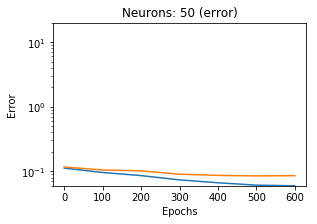

100/700 | Train/Valid error: 7.06%/9.25% 
200/700 | Train/Valid error: 5.11%/7.77% 
300/700 | Train/Valid error: 3.60%/6.80% 
400/700 | Train/Valid error: 2.61%/6.40% 
500/700 | Train/Valid error: 2.29%/6.46% 
600/700 | Train/Valid error: 2.03%/6.36% 
700/700 | Train/Valid error: 1.95%/6.42% 
Train/Valid error: 1.95%/6.42% 


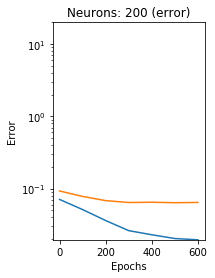

In [6]:
# Load train and test data
X_train, y_train = load_mnist('mnist/', kind='train')
r = np.random.RandomState(1)
idx = r.choice(y_train.shape[0],10000,replace=False)
X_train, y_train = X_train[idx], y_train[idx]
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
    
X_test, y_test = load_mnist('mnist/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

neurons = [50, 200]

plt.figure(figsize=(10,3))
for n, hidden in enumerate(neurons):
    #create a MLP object
    nn = MLP(n_output=10, 
             n_features=X_train.shape[1], 
             n_hidden=hidden, 
             l2=0.0, 
             l1=0.0, 
             epochs=700, 
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1)
    
    # Fit the data with NN
    nn.fit(X_train, y_train, print_progress=False,
             validation_freq=100,
             X_val=X_test, y_val=y_test)
    
    iter = [ i*100 for i in range(700 // 100)]
    plt.subplot(1,len(neurons),n+1)
    plt.plot(iter, nn.train_err_)
    plt.plot(iter, nn.val_err_)
    plt.yscale('log')
    plt.ylim([0, 20])
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.title("Neurons: {0} (error)".format(hidden))
    
    # Print the training accuracy and test accuracy in percentage for each value of hidden layer size. (0.5 point) 
    # TODO
    y_train_pred = nn.predict(X_train)
    y_val_pred = nn.predict(X_test)

    train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
    
    val_acc = ((np.sum(y_test == y_val_pred)).astype(np.float) / X_test.shape[0])
    
    train_error = 1 - train_acc
    val_error = 1 - val_acc
    print('Train/Valid error: %.2f%%/%.2f%% ' % (train_error*100, val_error*100))
    
    plt.show()

a) Using these plots and the related variables from the code to make suggestions for an early stopping criteria for each hidden layer size. (1.5 points)

##### We can see from the both plots and the validation error that for 50 neurons a validation_freq of 600 iterations makes since. After that, the network overfits the training data.

##### For the second network (200 neurons), we can see that a validation_freq of 400 iterations makes a since, and after that the network start to overfit the data. 

b) As the number of neurons are increased, you will observe differences in the early stopping criteria for each hidden layer size. Why do you observe such differences? (2 points)

##### As the number of neurons in the hidden layer increases, the network starts to fit the training data early and with better results, and then it overfits the training data by memorizing the training data, which would work well on the training data but will not generalize well on the test data. 

### Exercise 3. Regularization: Dropout (7 points)

**Goal:** To implement and study dropout for neural networks.

Implement dropout for layer 2 in the three-layered network you developed for Exercise 2. A simple dropout implementation creates a mask ($r^{(l)}_j$) for every neuron $j$ of the hidden layer $l$ by drawing from a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with probability $p$.
$$ r^{(l)}_j \sim Bernoulli(p) $$
This mask is then applied to the hidden layer output ($h^{(l)}$) to obtain the regularized hidden layer activation $\hat{h}^{(l)}$
$$ \hat{h}^{(l)} = r^{(l)} * h^{(l)}$$
However, such an implementation requires the layerl be multiplied by the dropout coefficient $p$ at evaluation time to balance the larger number of active units during testing.
$$ \hat{h}^{(l)} = p * h^{(l)}$$
Such an implementation requires the code to switch between different code blocks for forward-pass evaluation during training and testing. Hence, a smoother way to implement dropout is to use ***inverted dropout*** where the mask generated at the training is multiplied by the inverse of the dropout coefficient.
$$ r^{(l)}_j \sim Bernoulli(p) * \frac{1}{p}$$
This scheme allows the scaling to be learned during training and hence, no switching between code blocks is required.

Update the code below (specified by #TODO) to implement inverted dropout for a hidden layer size of 50 neurons. Running the code will show you variation of training and test accuracy for the dropout values given in the code below. 

---

In [9]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from __future__ import division
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels
  

class MLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
        
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
        
    n_hidden : int (default: 30)
        Number of hidden units.
        
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
        
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
        
    epochs : int (default: 500)
        Number of passes over the training set.
        
    eta : float (default: 0.001)
        Learning rate.
        
    alpha : float (default: 0.0)
        Momentum constant.
        
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
        
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
        
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
        
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
    
    dropout : float (default: 0.5)
        Set the dropout coefficient

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """

      
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=50, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=1, dropout = 0.5):

        self.n_output = n_output
        self.r = np.random.RandomState(random_state)
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

        # Initialize the class variable "dropout" like other variables above. Also, initialize a variable mask to None.
        # This will allow sharing dropout information during forward and backward pass of the neural networks. Note 
        # that the __init__ function has already been modified to include dropout coefficient as an argument. (0.5 points)
        #TODO
        self.dropout = dropout
        self.mask = None

    def _encode_labels(self, y, k):    
        """Encode the labels using one-hot representation

        Parameters
        ------------
        y : y represents target values.

        Returns
        -----------
        onehot array

        """
       
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        
        w1 = self.r.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = self.r.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        
        
        
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        
        # Implement inverted dropout using class variables dropout and activation variable (a2) for the forward
        # pass for the second hidden layer below. To create the mask you will have to use self.r.binomial for 
        # generating the bernoulli distribution. The mask created here needs to be stored in the appropriate mask
        # variable defined in the __init__ function for further use by the backward pass. (2.5 points)
        #TODO
        
        self.mask = np.random.binomial(1, self.dropout, a2.shape) / self.dropout

        masked_a2 = self.mask * a2


        z3 = w2.dot(masked_a2)
        a3 = self._sigmoid(z3)
        
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        np.seterr(divide='ignore')
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        
        term1[np.isneginf(term1)] = 0
        term2[np.isneginf(term2)] = 0
        
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        
        return cost

    def _get_gradient(self, a1, a2, a3, z2, z3, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.
        """
        
        # backpropagation
        sigma3 = (a3 - y_enc) #* self._sigmoid_gradient(z3)
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        
        # Implement dropout for the backward pass, use class variables for mask and dropout for this task (2.5 points)
        # TODO
        
        masked_a2 = a2 * self.mask
        sigma2 = sigma2 * self.mask

        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(masked_a2.T)

        # regularize
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                print('\nEpoch: %d/%d' % (i+1, self.epochs))

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2, z3=z3,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self


# Load train and test data
X_train, y_train = load_mnist('mnist/', kind='train')
r = np.random.RandomState(1)
idx = r.choice(y_train.shape[0],5000,replace=False)
X_train, y_train = X_train[idx], y_train[idx]
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
    
X_test, y_test = load_mnist('mnist/', kind='t10k')
idx = r.choice(y_test.shape[0],5000,replace=False)
X_test, y_test = X_test[idx], y_test[idx]
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))
  
vals = np.arange(0.1, 1.0, 0.2)
for dropout in vals:
    # create a MLP object
    print('Dropout: %.2f' % dropout)
    nn = MLP(n_output=10, 
             n_features=X_train.shape[1], 
             n_hidden=50, 
             l2=0.0, 
             l1=0.0, 
             epochs=500, 
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1,
             dropout = dropout)
    
    # Fit the data with NN
    nn.fit(X_train, y_train, print_progress=False)
    
    # Print the training accuracy and test accuracy in percentage for each value of dropout. This part is same as 
    # a question asked in Exercise 2, so you may use the code from there. (0 points) 
    # TODO
    nn.dropout = 1
    prediction_train = nn.predict(X_train)
    training_accuracy = np.sum(prediction_train == y_train, axis = 0) / X_train.shape[0]
    prediction_test = nn.predict(X_test)
    test_accuracy = np.sum(prediction_test == y_test, axis = 0) / X_test.shape[0]
    train_error = 1 - training_accuracy
    val_error = 1 - test_accuracy
    print('Train/Valid error : %.2f%%/%.2f%% ' % (train_error*100, val_error*100))



Rows: 5000, columns: 784
Rows: 5000, columns: 784
Dropout: 0.10
Train/Valid error : 43.22%/44.72% 
Dropout: 0.30
Train/Valid error : 17.08%/18.66% 
Dropout: 0.50
Train/Valid error : 10.78%/12.46% 
Dropout: 0.70
Train/Valid error : 8.54%/10.64% 
Dropout: 0.90
Train/Valid error : 9.00%/11.34% 


a) Intuitively, L1 and L2 minimize the interdependence and the value of feature weights by penalising the loss function. In the same vein, what kind of interdependence does dropout affect? (0.5 points)

##### Dropout helps reducing interdependent learning between the units (neurons).

b) Why can Dropout be considered as an approximation to Bagging? (1 point)

##### As we have seen in the 1st question, Bagging train multiple learners (Decision Trees) on different samples generated from the training data which allows to learn several independent representations of the patterns in the data. Dropout works the same, by training multiple networks (different neworks are trained due to ignoring some randomly neurons during training) which make each network also learn a different independent representation of the patterns in the data.

## Submission instructions
You should provide a single Jupyter notebook as a solution. The naming should include the assignment number and matriculation IDs of all team members in the following format:
**assignment-7_matriculation1_matriculation2_matriculation3.ipynb** (in case of 3 team members). 
Make sure to keep the order matriculation1_matriculation2_matriculation3 the same for all assignments.

Please, submit your solution to your tutor (with **[NNIA][assignment-7]** in email subject):
1. Maksym Andriushchenko s8mmandr@stud.uni-saarland.de
2. Marius Mosbach s9msmosb@stud.uni-saarland.de
3. Rajarshi Biswas rbisw17@gmail.com
4. Marimuthu Kalimuthu s8makali@stud.uni-saarland.de

**If you are in a team, please submit only 1 solution to only 1 tutor.**